In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
#to create custom dataset pytorch inbuilt class used

from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, lang_sentences):
        self.english_sentences = english_sentences
        self.lang_sentences = lang_sentences
    #rturn number of eng/hind or sentences in a list
    def __len__(self):
        return len(self.english_sentences)
    #return 1:1 mapping of one lang to other
    def __getitem__(self, idx):
        return self.english_sentences[idx], self.lang_sentences[idx]



In [7]:

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model,padding_idx=0)
        self.language_to_index = language_to_index
        self.position_encoder = RoPEEmbedding(d_model)  # Ensure RoPEEmbedding is defined
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN


    def batch_tokenize(self, batch, start=False, end=False):
        def tokenize(sentence):
            # Convert each character/token to its index
            sentence_word_indices = [self.language_to_index.get(token, self.language_to_index[self.PADDING_TOKEN]) for token in list(sentence)]

            if start:
                sentence_word_indices.insert(0, self.language_to_index[self.START_TOKEN])
            if end:
                sentence_word_indices.append(self.language_to_index[self.END_TOKEN])

            # Ensure all sequences are exactly max_sequence_length long
            sentence_word_indices = sentence_word_indices[:self.max_sequence_length]  # Truncate if too long
            sentence_word_indices += [self.language_to_index[self.PADDING_TOKEN]] * (self.max_sequence_length - len(sentence_word_indices))  # Pad if too short

            return torch.tensor(sentence_word_indices)

        tokenized = [tokenize(sentence) for sentence in batch]
        tokenized = torch.stack(tokenized)  # Convert list of tensors to a single tensor

        return tokenized  #(batch,seqlen)

    def forward(self, x, start=False, end=False):
        x = self.batch_tokenize(x, start, end)  # Ensure consistent function calls
        x = self.embedding(x)  # Convert token indices to embeddings
        #pos = self.position_encoder(x)  # Apply positional encoding
        #x = self.dropout(x + pos)  # Apply dropout
        return x #(batch,seqlen)


#rope embedding
class RoPEEmbedding(torch.nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        assert embedding_dim % 2 == 0, "Embedding dimension must be even for RoPE"
        self.embedding_dim = embedding_dim

    def forward(self, x):
        """
        Forward pass for Rotary Position Embedding.

        Args:
        - x: Tensor of shape (batch_size, seq_len, embedding_dim)

        Returns:
        - Tensor with RoPE applied to the last two dimensions.
        """
        seq_len = x.shape[1]

        # Generate position indices
        position_ids = torch.arange(seq_len, dtype=torch.float32, device=x.device)

        # Compute the rotary angles
        freqs = 1.0 / (10000 ** (torch.arange(0, self.embedding_dim, 2, dtype=torch.float32, device=x.device) / self.embedding_dim))
        angles = torch.einsum('i,j->ij', position_ids, freqs)

        # Create the rotation matrix for sin and cos embeddings
        sin = torch.sin(angles).repeat_interleave(2, dim=-1)
        cos = torch.cos(angles).repeat_interleave(2, dim=-1)

        # Apply rotation using cos and sin embeddings
        x1 = x * cos + self.rotate_half(x) * sin
        return x1


    def rotate_half(self,x):
        """
        Rotate the last dimension of the input tensor by swapping odd and even elements and negating one.

        Args:
        - x: Tensor of shape (..., embedding_dim)

        Returns:
        - Rotated tensor of the same shape.
        """
        x1, x2 = x[..., ::2], x[..., 1::2]  # Split into even and odd dimensions
        return torch.cat((-x2, x1), dim=-1)

#sine embedding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Generate the positional encoding
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)

        # Ensure the PE matches the batch size and sequence length
        PE = PE.unsqueeze(0).expand(batch_size, seq_len, self.d_model)

        return PE + x

To summarize:

Encoder: Padding mask is applied.

Decoder (Self-Attention): Both padding mask and look-ahead mask are applied.

Decoder (Cross-Attention): Only the padding mask is applied

In [8]:

#feedforward network
class feedforward(nn.Module):
  def __init__(self,d_model,hidlayer,dropout):
    super().__init__()
    self.d_model=d_model
    self.hidlayer=hidlayer
    self.linearlayer1=nn.Linear(self.d_model,self.hidlayer)
    self.linearlayer2=nn.Linear(self.hidlayer,self.d_model)
    self.dropout=nn.Dropout(dropout)
    self.activation=nn.ReLU()

  def forward(self,x):
    l1=self.linearlayer1(x)
    l1=self.activation(l1)
    l1=self.dropout(l1)
    out=self.linearlayer2(l1)
    out=self.dropout(out)
    return out

#multhead attention
class multihead_attention(nn.Module):
    def __init__(self,dmodel,heads=1):
        super().__init__()
        self.heads = heads
        self.dmodel=dmodel
        assert self.dmodel % self.heads == 0, "Embedding dimension must be divisible by num_heads"

        self.dmodel = dmodel
        self.head_dim = self.dmodel // self.heads
        self.wq = nn.Linear(self.dmodel, self.dmodel)
        self.wk = nn.Linear(self.dmodel, self.dmodel)
        self.wv = nn.Linear(self.dmodel, self.dmodel)
        self.linearlayer=nn.Linear(self.dmodel,self.dmodel)



    def scaled_dot_product_attention(self, q, k, v, padding_mask=None, look_ahead_mask=None):
    # Calculate scaled dot-product attention
        dk = q.shape[-1]  # Feature dimension per head
        scaled = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(dk, dtype=torch.float32))

        # Combine padding mask and causal mask if both are provided
        if padding_mask is not None and look_ahead_mask is not None:
            # Combine masks: Where padding exists, invalidate causal mask values
            combined_mask = look_ahead_mask.masked_fill(padding_mask==1,-1e9)  # Trapezoidal shape
            scaled = scaled.masked_fill(combined_mask == 0, -1e9)

        elif padding_mask is not None:  # Apply padding mask only
            scaled = scaled.masked_fill(padding_mask == 1, -1e9)

        elif look_ahead_mask is not None:  # Apply causal mask only
            scaled = scaled.masked_fill(look_ahead_mask == 0, -1e9)

        attention = torch.softmax(scaled, dim=-1)
        scores = torch.matmul(attention, v)
        return attention, scores

    def forward(self, x,padding_mask,look_ahead_mask):
        batch_size, sequence_length, input_dim = x.size()
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        q = q.view(batch_size, sequence_length, self.heads, self.head_dim)
        k = k.view(batch_size, sequence_length, self.heads, self.head_dim)
        v = v.view(batch_size, sequence_length, self.heads, self.head_dim)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attention, scores = self.scaled_dot_product_attention(q, k, v,padding_mask,look_ahead_mask)
        scores = scores.reshape(batch_size, sequence_length, self.heads *self.head_dim)# we can use self.dmodel as well as last arg
        out=self.linearlayer(scores)
        return out



#layer norm
class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape, epsilon=1e-5):
        super(CustomLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        self.epsilon = epsilon

    def forward(self, x):
        # Calculate mean and std across the last dimension (features) for each sequence in the batch
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_normalized = (x - mean) / (std + self.epsilon)

        # Apply gamma and beta, which are learned parameters for normalization
        # The shape of gamma and beta should match the feature size
        return self.gamma.unsqueeze(0).unsqueeze(0) * x_normalized + self.beta.unsqueeze(0).unsqueeze(0)



class multihead_cross_attention(nn.Module):
    def __init__(self, dmodel, heads=1):
        super().__init__()
        self.heads = heads

        assert dmodel % heads == 0, "Embedding dimension must be divisible by num_heads"

        self.dmodel = dmodel
        self.head_dim = self.dmodel // self.heads
        self.wqc = nn.Linear(self.dmodel, self.dmodel)
        self.wkc = nn.Linear(self.dmodel, self.dmodel)
        self.wvc = nn.Linear(self.dmodel, self.dmodel)
        self.linearlayer=nn.Linear(self.dmodel,self.dmodel)

    def scaled_dot_product_attention(self, q, k, v,padding_mask):
        dk = torch.tensor(q.shape[-1], dtype=torch.float32)
        scaled = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(dk)



        if padding_mask is not None:
            scaled = scaled.masked_fill(padding_mask==0,-1e9)

        attention = torch.softmax(scaled, dim=-1)
        scores = torch.matmul(attention, v)
        return attention, scores

    def forward(self, x,y,padding_mask):
        batch_size, sequence_length, input_dim = x.size()
        # if y.size(0) != x.size(0):
        #      pad_size = x.size(0) - y.size(0)
        #      padding = torch.zeros(pad_size, y.size(1), y.size(2), device=y.device)
        #      y = torch.cat([y, padding], dim=0)

        #print('x and y shape cross attention',x.shape,y.shape)

        # q and k from decoder
        q = self.wqc(x)
        k = self.wkc(y)
        # v from decoder
        v = self.wvc(y)
        q = q.view(batch_size, sequence_length, self.heads, self.head_dim)
        k = k.view(batch_size, sequence_length, self.heads, self.head_dim)
        v = v.view(batch_size, sequence_length, self.heads, self.head_dim)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attention, scores = self.scaled_dot_product_attention(q, k, v,padding_mask)
        scores = scores.reshape(batch_size, sequence_length, self.heads *self.head_dim)# we can use self.dmodel as well as last arg
        out=self.linearlayer(scores)
        return out




In [9]:
#encoder


#encoder layer

class encoderlayer(nn.Module):
  def __init__(self,max_sequence_length,d_model,hidlayer,dropout,num_heads):
    super().__init__()
    self.d_model,self.hidlayer,self.dropout,self.num_heads=d_model,hidlayer,dropout,num_heads
    self.multihead_attention=multihead_attention(d_model,num_heads)
    self.feedforward=feedforward(self.d_model,self.hidlayer,self.dropout)
    self.layernorm1=CustomLayerNorm(self.d_model)
    self.layernorm2=CustomLayerNorm(self.d_model)
    self.max_sequence_length=max_sequence_length

  def forward(self,x,padding_mask,look_ahead_mask):
    #mulihead
    mha=self.multihead_attention(x,padding_mask,look_ahead_mask)
    #layernorm
    ln1=self.layernorm1(mha+x)
    #feedforward
    ff=self.feedforward(ln1)
    #layernorm
    out=self.layernorm2(ff+ln1)
    return out



class encoder(nn.Module):
  #creating n layer of layers
  def __init__(self,max_sequence_length,d_model,hidlayer,dropout,num_heads,nlayers,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN
               ):
    super().__init__()
    #sequentially stack encoders
    self.encoderembeddings=SentenceEmbedding(max_sequence_length,d_model,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
    self.layers=nn.Sequential(*[encoderlayer(max_sequence_length,d_model,hidlayer,dropout,num_heads) for _ in range(nlayers)])

  def forward(self, x,padding_mask,look_ahead_mask,start,end):
    x=self.encoderembeddings(x,)
    for i, layer in enumerate(self.layers):
      #print(f'\n------layer {i+1}----- ')

      x = layer(x,padding_mask,look_ahead_mask)
      #print(f"--Output after layer {i+1}--: {x.size()}")  # Printing the size after each layer
    return x




In [10]:
#decoder
class decoderlayer(nn.Module):
  def __init__(self,max_sequence_length,d_model,hidlayer,dropout,num_heads):
    super().__init__()
    self.d_model,self.hidlayer,self.dropout,self.num_heads=d_model,hidlayer,dropout,num_heads
    #self.PositionalEncoding=PositionalEncoding(self.d_model,self.input_dim) #sinencoding
    self.multihead_attention=multihead_attention(self.d_model,self.num_heads)
    self.layernorm1=CustomLayerNorm(self.d_model)
    self.cross_attention=multihead_cross_attention(d_model,num_heads)
    self.layernorm2=CustomLayerNorm(self.d_model)
    self.feedforward=feedforward(self.d_model,self.hidlayer,self.dropout)
    self.layernorm3=CustomLayerNorm(self.d_model)
    self.max_sequence_length=max_sequence_length


  def forward(self,x,y,padding_mask,look_ahead_mask):
    if y.size(0) != x.size(0):
             pad_size = x.size(0) - y.size(0)
             padding = torch.zeros(pad_size, y.size(1), y.size(2), device=y.device)
             y = torch.cat([y, padding], dim=0)

    #multihead attention
    mha=self.multihead_attention(y,padding_mask,look_ahead_mask)
    #layernorm1
    ln1=self.layernorm1(mha+y)
    #cross attention
    cmha=self.cross_attention(x,ln1,padding_mask)
    #layernorm2
    ln2=self.layernorm2(cmha+ln1)

    #feedforward
    ff=self.feedforward(ln1)
    #layernorm3
    out=self.layernorm3(ff+ln2)
    return out

class decoder(nn.Module):
  #creating n layer of layers
  def __init__(self,max_sequence_length,d_model,hidlayer,dropout,num_heads,nlayers,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN
               ):
    super().__init__()
    #sequentially stack encoders
    self.decoderembeddings=SentenceEmbedding(max_sequence_length,d_model,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
    self.layers=nn.Sequential(*[decoderlayer(max_sequence_length,d_model,hidlayer,dropout,num_heads) for _ in range(nlayers)])

  def forward(self, x,y,start,end,padding_mask,look_ahead_mask):
    y = self.decoderembeddings(y, start,end)
    for i, layer in enumerate(self.layers):
      #print(f'\n------layer {i+1}----- ')
      l = layer(x,y,padding_mask,look_ahead_mask)
      #print(f"--Output after layer {i+1}--: {l.size()}")  # Printing the size after each layer
    return l




In [11]:
#now the transformer class
#transformer class
class mytransformer(nn.Module):
  def __init__(self,
               d_model,
               hidlayer,
               dropout,
               num_heads,
               nlayers,
               lang_vocab_size,
               english_to_index,
               lang_to_index,
               max_seq_len,
               START_TOKEN,
               END_TOKEN,
               PADDING_TOKEN):

    super().__init__()
    self.d_model=d_model
    self.hidlayer=hidlayer
    self.dropout=dropout
    self.num_heads=num_heads
    self.nlayers=nlayers
    self.vocab_size=lang_vocab_size
    self.english_to_index = english_to_index
    self.lang_to_index = lang_to_index
    self.max_sequence_length = max_seq_len
    self.START_TOKEN = START_TOKEN
    self.END_TOKEN = END_TOKEN
    self.PADDING_TOKEN = PADDING_TOKEN


    self.Encoder=encoder(self.max_sequence_length,self.d_model,self.hidlayer,self.dropout,self.num_heads,self.nlayers,
                         self.english_to_index,self.START_TOKEN,self.END_TOKEN,self.PADDING_TOKEN
               )
    self.Decoder=decoder(self.max_sequence_length,self.d_model,self.hidlayer,self.dropout,self.num_heads,self.nlayers,
                         self.lang_to_index,self.START_TOKEN,self.END_TOKEN,self.PADDING_TOKEN
               )
    self.linearlayer=nn.Linear(self.d_model,self.vocab_size)

  def forward(self,english_sentences,hindi_sentences,encodermask=None,decodermask=None,decoder_cross_attention_mask=None):
    x=self.Encoder(english_sentences,padding_mask=encodermask,look_ahead_mask=None,start=False,end=False)
    y=self.Decoder(x,hindi_sentences,padding_mask=decodermask,look_ahead_mask=decoder_cross_attention_mask,start=True,end=True,)
    y=self.linearlayer(y)
    #print('output of linear layer',y.shape)
    #softmaxoutput=torch.log_softmax(y,dim=-1)
    #print('output of softmax layer',softmaxoutput.shape)
    #return softmaxoutput
    #predict next tokens
    #predicted_tokens = torch.argmax(softmaxoutput, dim=-1)  # Shape: (3, 5)
    # predict next token
    #predicted_next_token = torch.argmax(softmaxoutput[-1, -1, :])  # Shape: ()
    # predict next tokens
    #predicted_next_tokens = torch.argmax(softmaxoutput[:, -1, :],dim=-1)  # Shape: ()
    return y #(batch,seqlen,vocabsize)



In [12]:
#vocab

START_TOKEN = "<START>"
END_TOKEN = "<END>"
PADDING_TOKEN = "<PAD>"

english_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', '@',
                      'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                      'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                      'Y', 'Z', '[', '\\', ']', '^', '_', '`',
                      'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                      'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                      'y', 'z', '{', '|', '}', '~', START_TOKEN,PADDING_TOKEN, END_TOKEN]



hindi_vocabulary = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ँ', 'ं', 'ः',
                    'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ए', 'ऐ', 'ओ', 'औ',
                    'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण',
                    'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह',
                    '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ॐ',
                    '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', START_TOKEN,PADDING_TOKEN, END_TOKEN]

index_to_hindi = {k:v for k,v in enumerate(hindi_vocabulary)}
hindi_to_index = {v:k for k,v in enumerate(hindi_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#dataset creation

data=pd.read_csv('/content/drive/MyDrive/ADeepLearning/hindi_english_parallel2.csv')
data.head()

,English,Hindi
0,Help!,बचाओ!
1,Jump.,उछलो.
2,Jump.,कूदो.
3,Jump.,छलांग.
4,Hello!,नमस्ते।


In [15]:
data.dropna(inplace=True)
data.shape

(130162, 2)

In [16]:
data.isnull().sum()

,0
English,0
Hindi,0


In [17]:

sample=data[:10000].copy()
engsen1=sample['English'].to_list()
hindisen1=sample['Hindi'].to_list()
# Ensure all values are strings
hindisen1 = ["" if isinstance(sent, float) else str(sent) for sent in hindisen1]
engsen1 = ["" if isinstance(sent, float) else str(sent) for sent in engsen1]


In [18]:
# Find new unique characters
unique_chars_in_data = set("".join(hindisen1))
missing_chars = unique_chars_in_data - set(hindi_vocabulary )

# Add missing characters
hindi_vocabulary .extend(missing_chars)
hindi_vocabulary  = sorted(set(hindi_vocabulary ))  # Ensure uniqueness and order

print("✅ Updated Hindi Vocabulary Size:", len(hindi_vocabulary ))
print("✅ New Characters Added:", missing_chars)

✅ Updated Hindi Vocabulary Size: 206
✅ New Characters Added: {'{', 'q', 't', 'S', 'u', 'ख़', 'ऑ', 'ت', 'ॡ', 'e', 'O', '̈', 'ٕ', '[', 'C', 'ا', 'W', 'م', 'k', 'c', 's', '`', 'ح', 'd', 'ज़', 'F', 'h', 'b', '☻', ';', 'L', 'V', 'A', '‘', 'ऍ', 'ऒ', 'n', 'ل', 'ऎ', 'x', 'o', 'g', 'ळ', '☺', 'y', 'H', 'ج', '♫', 'E', 'N', 'X', 'G', 'D', 'ॊ', 'Z', 'I', '\\', 'p', '“', '́', 'U', 'Q', '\u200c', '\u200e', 'w', '~', '\u200b', 'Y', 'f', 'J', ']', '@', 'M', 'm', 'z', 'a', 'r', 'i', '।', '·', 'l', 'P', '_', '॰', 'R', 'B', 'س', 'ढ़', 'ड़', 'j', '|', '°', 'K', '\u200d', '”', 'T', 'v'}


In [19]:


index_to_hindi = {k:v for k,v in enumerate(hindi_vocabulary)}
hindi_to_index = {v:k for k,v in enumerate(hindi_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [20]:
len(index_to_hindi)

206

In [21]:


max_sequence_length = 5000  # Maximum allowed characters
min_sequence_length = 1  # Minimum required characters
# Ensure all values are strings
hindisen1 = ["" if isinstance(sent, float) else str(sent) for sent in hindisen1]
engsen1 = ["" if isinstance(sent, float) else str(sent) for sent in engsen1]

# Function to check if a sentence contains only valid tokens
def is_valid_tokens(sentence, vocab):
    for token in list(set(sentence)):  # Ensure unique characters are checked
        if token not in vocab:
            return False
    return True

# Function to check if sentence length is within min & max limits
def is_valid_length(sentence, min_length, max_length):
    sentence_length = len(sentence)  # No need to convert to list explicitly
    return min_length <= sentence_length < max_length  # Ensuring it fits the range

valid_sentence_indices = []
for index in range(len(hindisen1)):
    hindi_sentence, english_sentence = hindisen1[index], engsen1[index]

    if (is_valid_length(hindi_sentence, min_sequence_length, max_sequence_length) and
        is_valid_length(english_sentence, min_sequence_length, max_sequence_length) and
        is_valid_tokens(hindi_sentence, hindi_vocabulary)):

        valid_sentence_indices.append(index)

print(f"Total sentences: {len(hindisen1)}")
print(f"Valid sentences: {len(valid_sentence_indices)}")


Total sentences: 10000
Valid sentences: 10000


In [22]:
hindisen2 = [hindisen1[i] for i in valid_sentence_indices]
engsen2 = [engsen1[i] for i in valid_sentence_indices]


In [23]:
#data creation

In [24]:
batch_size = 30
dataset = TextDataset(engsen2, hindisen2)
train_loader = DataLoader(dataset, batch_size,shuffle=True)
iterator = iter(train_loader)
d_model = 64
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 1
max_sequence_length = 6
hn_vocab_size=len(hindi_to_index)

transformer=mytransformer(d_model,ffn_hidden,drop_prob,num_heads,num_layers,
                          hn_vocab_size,english_to_index,hindi_to_index,max_sequence_length,START_TOKEN,END_TOKEN,PADDING_TOKEN)


transformer.Decoder.decoderembeddings.batch_tokenize(['मेरे'],start=True,end=True)

tensor([[ 31, 151, 171, 153, 171,  29]])

In [25]:
len(engsen2[:9000]),len(engsen2[9000:])

(9000, 1000)

In [26]:
batch_size = 30
dataset = TextDataset(engsen2, hindisen2)
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [27]:
#train
batch_size = 30
train_dataset = TextDataset(engsen2[:9000], hindisen2[:9000])
test_dataset = TextDataset(engsen2[9000:], hindisen2[:9000:])
train_loader = DataLoader(train_dataset, batch_size,shuffle=True)
validation_loader= DataLoader(test_dataset, batch_size,shuffle=True)
iterator = iter(train_loader)
iterator1 = iter(validation_loader)
d_model = 64
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 8
max_sequence_length = 100
hn_vocab_size=len(hindi_to_index)

transformer=mytransformer(d_model,ffn_hidden,drop_prob,num_heads,num_layers,
                          hn_vocab_size,english_to_index,hindi_to_index,max_sequence_length,START_TOKEN,END_TOKEN,PADDING_TOKEN)



In [28]:
def create_mask(input, pad):
    # Padding mask: Shape (batch_size, 1, 1, seq_len), where True indicates padding
    pmask = (input == pad).unsqueeze(1).unsqueeze(2)

    # Look-ahead mask: Shape (1, 1, seq_len, seq_len)
    seq_len = input.size(1)  # Get sequence length
    clmask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=input.device))
    clmask = clmask.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, seq_len, seq_len)

    return pmask, clmask

In [29]:

#set loss func and init params

criterian = nn.CrossEntropyLoss(ignore_index=hindi_to_index[PADDING_TOKEN],
                                reduction='none')

# When computing the loss, we are ignoring cases when the label is the padding token
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)

In [30]:
dataset.english_sentences[200]

'How old are you?'

In [31]:
english_to_index[PADDING_TOKEN],hindi_to_index[PADDING_TOKEN]

(95, 30)

In [32]:
transformer.train()

train_loss = []
validation_loss=[]
num_epochs = 100

for epoch in range(num_epochs):
    print("*"*500)
    print(f"Epoch {epoch+1}")
    print("*"*500)
    iterator = iter(train_loader)

    for batch_num, batch in enumerate(iterator):
        if batch_num%500==0:
            print(f"Iteration {batch_num}")
            transformer.train()
            eng_batch, hn_batch = batch  # Get English and Hindi sentences
            optim.zero_grad()
            print(f"sample English: {eng_batch[22]}")
            print(f"sample hindi Translation: {hn_batch[22]}")
            encodermask,clmask=create_mask(transformer.Encoder.encoderembeddings.batch_tokenize(eng_batch,start=False,end=False),english_to_index[PADDING_TOKEN])
            decoderpadmask,crossattentionmask=create_mask(transformer.Decoder.decoderembeddings.batch_tokenize(hn_batch,start=True,end=True),hindi_to_index[PADDING_TOKEN])
            #encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask=create_mask(eng_batch,hn_batch)
            # Get predicted logits
            #predictions = transformer(eng_batch, hn_batch,encoder_self_attention_mask,decoder_self_attention_mask,decoder_cross_attention_mask)
            predictions = transformer(eng_batch, hn_batch,encodermask,decoderpadmask,crossattentionmask)

            #get labels
            targets = transformer.Decoder.decoderembeddings.batch_tokenize(hn_batch,start=True,end=True)
            # Compute loss
            loss = criterian(predictions.view(-1, predictions.shape[-1]), targets.view(-1))
            valid_indicies = (targets.view(-1) != hindi_to_index[PADDING_TOKEN])  # Ignore padding
            loss = loss[valid_indicies].mean()
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
            print(f"Loss: {loss.item()}")


            # Generate  predictions
            with torch.no_grad():
                hn_predictions = transformer(eng_batch, hn_batch)
                hn_sentence_predicted = torch.argmax(hn_predictions[22], axis=1)

                # Convert indices to  text
                maxtokens=50
                predicted_sentence = []
                count = 0

                for idx in hn_sentence_predicted:  # Directly iterate over the tensor
                    if idx.item() == hindi_to_index[END_TOKEN]: #or count >= maxtokens:
                      break
                    elif idx.item() == hindi_to_index[START_TOKEN]:
                      continue


                    predicted_sentence.append(index_to_hindi[idx.item()])  # Convert index to Hindi character
                    count += 1  # Increment token count


                predicted_sentence="".join(predicted_sentence)
                print(f"hindi Prediction:{predicted_sentence}")
                print("-"*500)

            #validation text
            transformer.eval()
            count=0

            hn_sentence = [START_TOKEN]
            eng_sentence = ("should we go to the mall?",)
            validationencodermask,validationclmask=create_mask(transformer.Encoder.encoderembeddings.batch_tokenize(eng_sentence,start=False,end=False),english_to_index[PADDING_TOKEN])
            validationdecoderpadmask,validationcrossattentionmask=create_mask(transformer.Decoder.decoderembeddings.batch_tokenize(hn_sentence,start=True,end=True),hindi_to_index[PADDING_TOKEN])

            evalpredictions = transformer(eng_sentence,
                                        hn_sentence,validationencodermask,validationdecoderpadmask,validationcrossattentionmask)
            evalpredictedsentence=torch.argmax(evalpredictions[0], axis=1)
            eval_predicted_sentence=[]
            for idx in evalpredictedsentence:
                if idx.item() == hindi_to_index[END_TOKEN]: #or count >= maxtokens:
                    break
                elif idx.item() == hindi_to_index[START_TOKEN]:
                    continue
                eval_predicted_sentence.append(index_to_hindi[idx.item()])
                count+=1
            eval_predicted_sentence="".join(eval_predicted_sentence)
            print(f"Evaluation translation (should we go to the mall?) : {eval_predicted_sentence}")
            print("-------------------------------------------")
            #break
    #break

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Epoch 1
***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [33]:
predictions.shape,targets.shape,predictions.view(-1, predictions.shape[-1]).shape, targets.view(-1).shape

(torch.Size([30, 100, 206]),
 torch.Size([30, 100]),
 torch.Size([3000, 206]),
 torch.Size([3000]))

In [34]:
targets.view(-1)[valid_indicies]

tensor([ 31, 154, 127,  ..., 165, 184,  29])

In [35]:
predictions.view(-1, predictions.shape[-1])[:2,:]

tensor([[ 0.4537, -0.3006,  0.4883,  0.3744, -0.5588,  0.1470, -0.1866, -0.6452,
         -0.6441, -0.0925, -0.5335, -0.8201,  0.0434, -0.1819,  0.4280,  0.3811,
         -0.7767,  0.0739, -0.8513, -0.6739,  0.4023,  0.9717, -1.2798, -0.3180,
         -1.0286, -1.2184, -0.1997, -0.1273, -0.4903,  0.7909,  0.6596,  4.1016,
          0.5629,  0.8984,  0.9722, -1.0076, -0.0713, -0.2796, -0.5392,  0.0414,
         -0.1118, -0.5423, -0.7862,  0.0843, -0.0895, -0.2045,  0.5863,  0.5110,
          0.9510, -0.5743, -1.2124,  0.0315,  0.0789,  0.0492,  0.3573,  0.1170,
         -0.6316, -0.6405, -1.3397, -0.7478, -0.0357,  0.6219, -0.5488, -0.3953,
          0.5340, -0.2691,  0.1719,  0.3505, -0.1411, -0.2791, -0.5651, -0.0401,
         -1.1069, -2.1184, -0.0905, -0.8099, -1.2047, -0.2310,  0.1928,  1.2777,
          0.2602,  0.0673, -1.2919, -1.1633,  0.5070,  0.2163, -0.2213, -0.5508,
          0.7341,  0.2737,  0.9880,  0.4582, -0.5137, -1.4326,  0.6298,  0.0396,
          0.6802,  0.3211, -

In [36]:
predictions.view(-1, predictions.shape[-1])[:2,:].shape

torch.Size([2, 206])

In [37]:
targets.view(-1, targets.shape[-1])[:2,:]

tensor([[ 31, 154, 127, 139, 161, 165,   0, 159, 171,   0, 149, 146, 165,   0,
         113, 151, 163, 153, 142, 175, 109,   0, 151, 171, 109,   0, 112, 129,
           0, 112, 159, 163, 146, 165,   0, 159, 171,   0, 154, 129,   0, 134,
         163, 142, 165,   0, 160, 172, 184,  29,  30,  30,  30,  30,  30,  30,
          30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,
          30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,
          30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,
          30,  30],
        [ 31, 152, 160, 165,   0, 146, 160, 165,   0, 134, 175,   0, 146, 163,
         151,   0, 147, 177, 153, 132, 154, 164, 142,   0, 146, 160, 165, 109,
           0, 153, 160, 171,   0, 115, 146, 127, 163,   0, 147, 177, 153, 152,
         175, 129,   0, 127, 153, 146, 171,   0, 147, 153,   0, 112, 147,   0,
         151, 167, 153, 177, 128,   0, 144, 164, 128, 163, 114,   0, 147, 139,
         161, 171, 109, 129, 171

In [38]:
targets.view(-1, targets.shape[-1])[:2,:].shape

torch.Size([2, 100])

In [39]:
# Correct reshaping
targets = targets.view(-1)
# Compute loss with correctly shaped targets
loss = criterian(predictions.view(-1, predictions.shape[-1])[:2,:], targets[:2])

# Ignore padding
valid_indices = (targets[:2] != hindi_to_index[PADDING_TOKEN])
loss = loss[valid_indices].mean()
loss

tensor(1.6368, grad_fn=<MeanBackward0>)

In [40]:
targets[:2]

tensor([ 31, 154])

In [41]:
hindi_to_index[PADDING_TOKEN]

30

In [42]:
targets.shape

torch.Size([3000])

In [43]:
# Correct reshaping
targets = targets.view(-1)
# Compute loss with correctly shaped targets
loss = criterian(predictions.view(-1, predictions.shape[-1]), targets)

# Ignore padding
valid_indices = (targets != hindi_to_index[PADDING_TOKEN])
targets.shape,predictions.view(-1, predictions.shape[-1]).shape,loss[valid_indices].shape


(torch.Size([3000]), torch.Size([3000, 206]), torch.Size([1665]))

In [44]:
engsent=eng_batch[-1]
hinsent=hn_batch[-1]
print('engsent',engsent)
print('hinsent',hinsent)
hn_predictions = transformer([engsent], [hinsent])
hn_sentence_predicted = torch.argmax(hn_predictions[0], axis=1)

# Convert indices to  text
maxtokens=50
predicted_sentence = []
count = 0

for idx in hn_sentence_predicted:  # Directly iterate over the tensor
    if idx.item() == hindi_to_index[END_TOKEN]:# or count >= maxtokens:
        break
    elif idx.item() == hindi_to_index[START_TOKEN]:
                      continue
    predicted_sentence.append(index_to_hindi[idx.item()])  # Convert index to Hindi character
    count += 1  # Increment token count


predicted_sentence="".join(predicted_sentence)
print(f"hindi Prediction:{predicted_sentence}")

engsent He has started playing in 1989.
hinsent उन्होंने अपने खेल की शुरुआत १९८९ मे की थी।
hindi Prediction: न्होंने कपने केल की सहर*ंत पववM मे की ाी 


In [45]:
engsent

'He has started playing in 1989.'

In [46]:
#inference
transformer.eval()
def translate(eng_sentence):
  engsent=[eng_sentence]
  hinsent=[START_TOKEN]
  hn_predictions = transformer(engsent, hinsent)
  hn_sentence_predicted = torch.argmax(hn_predictions[0], axis=1)

  # Convert indices to  text

  maxtokens=100
  predicted_sentence = []
  count = 0

  for idx in hn_sentence_predicted:  # Directly iterate over the tensor
      if idx.item() == hindi_to_index[END_TOKEN]:
          break
      predicted_sentence.append(index_to_hindi[idx.item()])  # Convert index to Hindi character
      count += 1  # Increment token count


  predicted_sentence="".join(predicted_sentence)
  print(f"hindi Prediction:{predicted_sentence}")

In [47]:
translate("I'd like to see her.")

hindi Prediction:<START>रसीििDस ीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीीी            पी  ीीी ीीीी पपपपपपपपपपपपपीीीीीीीीीीीी


In [48]:
index_to_hindi[180]

'ज़'

Text(0.5, 1.0, 'Training Loss')

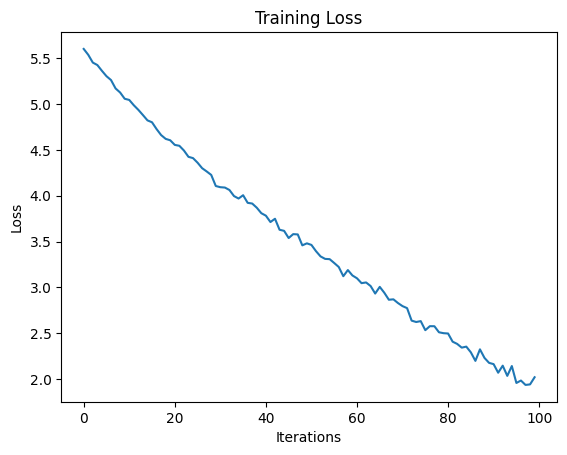

In [49]:
#plot loss
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')

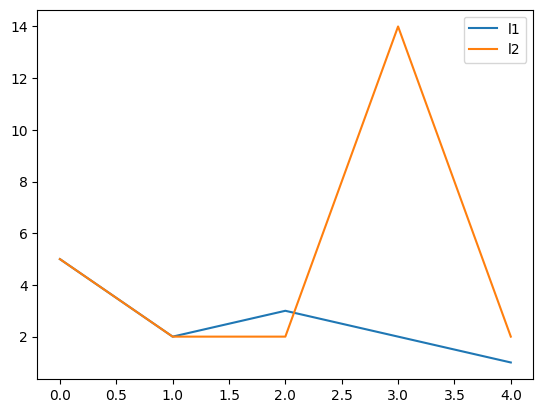

In [50]:
l1=[5,2,3,2,1]
l2=[5,2,2,14,2]
plt.plot(l1,label='l1')
plt.plot(l2,label='l2')
plt.legend()

In [51]:
asdsadsadsadsadsadasds

NameError: name 'asdsadsadsadsadsadasds' is not defined

In [69]:
def evaluate_model(data_loader, dataset_name=""):
    transformer.eval()  # Set model to evaluation mode
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in data_loader:
            # Create masks
            encodermask, clmask = create_mask(
                transformer.Encoder.encoderembeddings.batch_tokenize(batch_features, start=False, end=False),
                english_to_index[PADDING_TOKEN]
            )
            decoderpadmask, crossattentionmask = create_mask(
                transformer.Decoder.decoderembeddings.batch_tokenize(batch_labels, start=True, end=True),
                hindi_to_index[PADDING_TOKEN]
            )

            # Forward pass
            predictions = transformer(batch_features, batch_labels, encodermask, decoderpadmask, crossattentionmask)

            # Target labels
            targets = transformer.Decoder.decoderembeddings.batch_tokenize(batch_labels, start=True, end=True)

            # Ensure padding tokens are ignored
            valid_indices = targets != hindi_to_index[PADDING_TOKEN]  # Ignore padding
            valid_targets = targets[valid_indices]  # Filter targets
            valid_predictions = predictions.view(-1, predictions.shape[-1])[valid_indices.view(-1)]  # Filter predictions

            if valid_targets.numel() == 0:  # Skip batch if it contains no valid tokens
                continue

            # Compute correctness
            _, predicted = torch.max(valid_predictions, dim=-1)  # Get predicted token indices
            correct += (predicted == valid_targets).sum().item()  # Compare valid predictions and targets
            total += valid_targets.numel()  # Count valid tokens
            #print(predicted.shape)
            #print(valid_targets.shape)
            #break

    accuracy = correct / total if total > 0 else 0.0  # Prevent division by zero
    print(f"Accuracy on {dataset_name} Data: {accuracy:.4f}")
    return accuracy


# Evaluate on test data
print("Evaluating on Test Data...")
test_accuracy = evaluate_model(validation_loader, dataset_name="Test")

Evaluating on Test Data...
Accuracy on Test Data: 0.8407


In [64]:
#Evaluate on training data
print("Evaluating on Training Data...")
train_accuracy = evaluate_model(train_loader, dataset_name="Training")


Evaluating on Training Data...
Accuracy on Training Data: 0.8526
